In [287]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [288]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [289]:
len(words)

32033

In [290]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print (itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [291]:
def build_dataset(words):    
    block_size = 3
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [292]:
F.one_hot(torch.tensor(5), num_classes=27).float()

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [293]:
C = torch.randn(27, 2)

In [294]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [295]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [296]:
h = torch.tanh(emb.view(-1,6) @W1 + b1) # 32, 100

In [297]:
h.shape

torch.Size([228146, 100])

In [298]:
b1.shape

torch.Size([100])

In [299]:
w2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [300]:
logits = h @w2 + b2

In [301]:
logits.shape

torch.Size([228146, 27])

In [302]:
# Take these logits exponent, take count and then normalize them into probability.
counts = logits.exp()

In [303]:
# every row of prob sums to 1. so its normalized
#this is the prob of char. next comes the actual character which is array Y
prob = counts / counts.sum(1, keepdims=True)

In [304]:
prob[0].sum()

tensor(1.)

In [309]:
Y.shape

torch.Size([228146])

In [306]:
# prob[torch.arange(32), Y]

In [307]:
prob.shape

torch.Size([228146, 27])

In [311]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(17.7666)

In [312]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [313]:
sum(p.nelement() for p in parameters) # number of parameters in totla

11897

In [314]:
#counts = logits.exp()
#prob = counts/counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()


In [315]:
#set requires_grad to true
for p in parameters:
    p.requires_grad = True

In [316]:
lre = torch.linspace(-3, 0, 50000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9997, 0.9999, 1.0000])

In [317]:
lri = []
lossi = []
stepi = []

In [318]:


for i in range(50000):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #forward pass

    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 200
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Ytr[ix])



    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #updates
    lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    #lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())


2.143141984939575


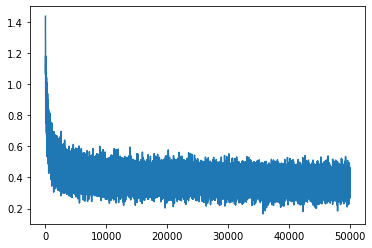

In [319]:
plt.plot(stepi, lossi)

In [320]:
#calculate the loss on train dataset
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 200
logits = h @ W2 + b2 # 32, 27
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3560, grad_fn=<NllLossBackward0>)

In [321]:
#evaluate the loss on dev dataset
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 200
logits = h @ W2 + b2 # 32, 27
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3827, grad_fn=<NllLossBackward0>)

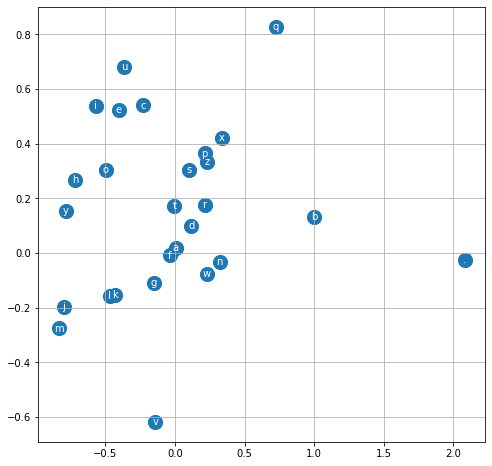

In [322]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [326]:
#sample from model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # 1(, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if (ix ==0):
            break
    print(''.join(itos[i] for i in out))

carpa.
zayleil.
khy.
myla.
taty.
halaysa.
jazon.
brah.
ryra.
kaqei.
nelania.
chriav.
brie.
yve.
bryn.
inderinn.
arlin.
alyan.
quinae.
ryiearyn.


In [132]:
logits.max(1)

torch.return_types.max(
values=tensor([14.4708, 20.0267, 21.6664, 22.1311, 18.3252, 14.4708, 17.5746, 15.4333,
        17.1932, 20.1970, 17.6565, 22.5574, 14.4708, 19.0565, 18.9148, 21.9043,
        14.4708, 18.2666, 17.2089, 18.9774, 19.9681, 17.7908, 12.5182, 12.1659,
        16.6915, 14.4708, 17.6280, 18.4646, 13.9206, 17.5055, 21.0083, 18.2590],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [145]:
a.max(0)

torch.return_types.max(
values=tensor([0.3891, 1.2320, 0.9124]),
indices=tensor([1, 1, 0]))

In [155]:
torch.randint(0, X.shape[0], (32,))

tensor([ 63487,  93988,  52942, 205574,  20839, 131437, 156649,   9182,  16643,
         61274, 160555, 190417, 196740, 147401,  68806,  67019,  55507, 158125,
        148153, 100558, 198692, 164989, 132405, 122677,  69918, 161938, 192082,
        156268, 136670, 114905,  86332, 214022])